# In-lecture k-NN

### Опросы к лекции

#### Опрос 1
Пусть даны две точки $x=\left(1, 3, -5, 7\right)$ и $x'=\left(2, -4, 0, 8\right)$. Вычислить евклидово расстояние $d_E$ между $x$ и $x'$.

Напомним, что евклидово расстояние вычисляется следующим образом:
$$
d_{E}\left(x, x'\right)=\sqrt{\left(1-2\right)^{2}+\left(3-(-4)\right)^{2}+\left(-5-0\right)^{2}+ \left(7-8\right)^{2} }
$$

In [ ]:
import numpy as np

x = np.array([1,3,-5,7])
x_prime = np.array([2,-4,0,8])

def eucl_dist(x,x_prime):
  dist = 0
  for coord_1, coord_2 in zip(x, x_prime):
    dist += (coord_1 - coord_2) ** 2
  return dist ** 0.5

eucl_dist(x, x_prime)

8.717797887081348

Теперь попользуемся [библиотеками](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html):

In [ ]:
from scipy.spatial import distance
distance.euclidean(x, x_prime)

8.717797887081348

Манхэттенское расстояние вычисляется следующим образом:
$$
d_{1}\left(x, x'\right)=\left|1-2\right|+\left|3-(-4)\right|+\left|-5-0\right|+ \left|7-8\right|
$$

In [ ]:
def manh_dist(x, x_prime):
  dist = 0
  for coord_1, coord_2 in zip(x, x_prime):
    dist += abs(coord_1 - coord_2)
  return dist

manh_dist(x, x_prime)

14

In [ ]:
distance.cityblock(x, x_prime)

14

Расстояние Чебышева вычисляется так:
$$
d_{\infty}\left(x, x'\right)=\max \left (\left|1-2\right|, \left|3-(-4)\right|,\left|-5-0\right|, \left|7-8\right| \right)
$$

In [ ]:
def cheb_dist(x, x_prime):
  dist = []
  for coord_1, coord_2 in zip(x, x_prime):
    dist.append(abs(coord_1 - coord_2))
  return max(dist)

cheb_dist(x, x_prime)

7

In [ ]:
distance.chebyshev(x, x_prime)

7

Показанные расстояния — частный случай реализации расстояния Минковского:
$$
d_p(x, x') = \left( \sum\limits_{i = 1}^n |x_i - x_i'|^p \right)^{1/p}, \ p \in \mathbb N \cup \{+\infty\}, \ x, x' \in \mathbb R^n.
$$
Библиотека об этом не знает.

In [ ]:
print(f'Manh. distance is:  {distance.minkowski(x, x_prime, 1)}')
print(f'Eucl. distance is:  {distance.minkowski(x, x_prime, 2)}')

Manh. distance is:  14.0
Eucl. distance is:  8.717797887081348


#### Опрос 2

Приведена таблица некоторых синтетических данных. Вы должны классифицировать новый объект с координатами $(33, 47)$ при помощи метода k-NN.
\begin{array}{|c|c|c|c|} \hline
\operatorname{id} & X & Y & \operatorname{Class} \\ \hline
1&	28&	10&	1 \\ \hline
2&	49&	49&	1 \\ \hline
3&48&	35&	0 \\ \hline
4&	36&	33&	1 \\ \hline
5&	45&	54&	0 \\ \hline
\end{array}


In [ ]:
import pandas as pd
import io

data = """id,X,Y,Class
1,28,10,1
2,49,49,1
3,48,35,0
4,36,33,1
5,45,54,0"""
df = pd.read_csv(io.StringIO(data), sep=",", index_col='id')
df

,X,Y,Class
id,,,
1,28,10,1
2,49,49,1
3,48,35,0
4,36,33,1
5,45,54,0


In [ ]:
x = np.array([33,47])
df['Euclidean'] = [distance.euclidean(obj, x) for index, obj in df.iloc[:,:2].iterrows()]
df

,X,Y,Class,Euclidean
id,,,,
1,28,10,1,37.336309
2,49,49,1,16.124515
3,48,35,0,19.209373
4,36,33,1,14.317821
5,45,54,0,13.892444


In [ ]:
df['Manhattan'] = [distance.cityblock(obj, x) for index, obj in df.iloc[:,:2].iterrows()]
df['Chebyshev'] = [distance.chebyshev(obj, x) for index, obj in df.iloc[:,:2].iterrows()]
df

,X,Y,Class,Euclidean,Manhattan,Chebyshev
id,,,,,,
1,28,10,1,37.336309,42,37
2,49,49,1,16.124515,18,16
3,48,35,0,19.209373,27,15
4,36,33,1,14.317821,17,14
5,45,54,0,13.892444,19,12


In [ ]:
df.style.highlight_min(['Euclidean', 'Manhattan', 'Chebyshev'], color = 'darkgreen', axis = 0)

,X,Y,Class,Euclidean,Manhattan,Chebyshev
id,,,,,,
1,28,10,1,37.336309,42,37
2,49,49,1,16.124515,18,16
3,48,35,0,19.209373,27,15
4,36,33,1,14.317821,17,14
5,45,54,0,13.892444,19,12


### k-NN

In [44]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

Для начала загрузим интересующие нас данные (Howell1: Howell !Kung demography data):

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=';')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


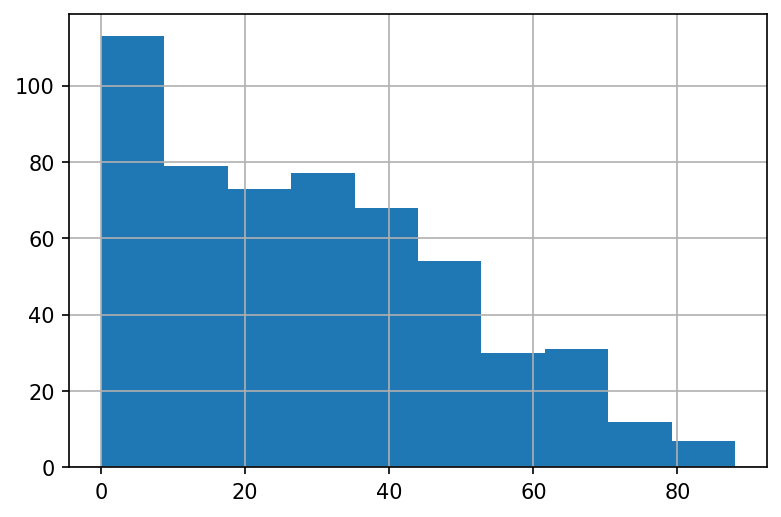

In [45]:
df['age'].hist()

Соберем выборку более ли менее «стандартных» людей:

In [46]:
df_sample = df.loc[(df['age'] >= 18) & (df['age'] <= 50)]
df_sample.head()

,height,weight,age,male
3,156.845,53.041914,41.0,1
5,163.830,62.992589,35.0,1
6,149.225,38.243476,32.0,0
7,168.910,55.479971,27.0,1
8,147.955,34.869885,19.0,0


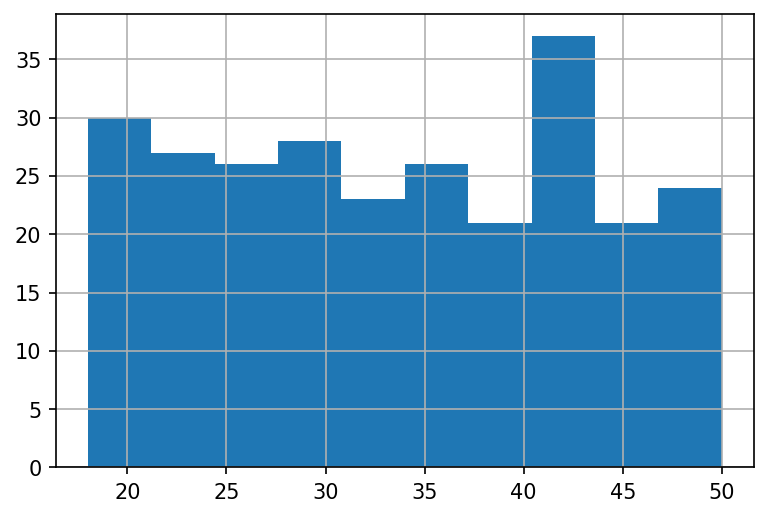

In [47]:
df_sample['age'].hist()

Визуализируем то, что у нас получилось:

In [48]:
import matplotlib.pyplot as plt

In [49]:
def plot(df):
    plt.figure(figsize=(20,10)) 
    plt.scatter(df.weight[df.male == 1], df.height[df.male == 1], color = 'blue', label = 'male')
    plt.scatter(df.weight[df.male == 0], df.height[df.male == 0], color = 'red', label = 'female')
    plt.legend(loc = [1.1, 0.5])
    plt.ylabel('рост')
    plt.xlabel('масса')

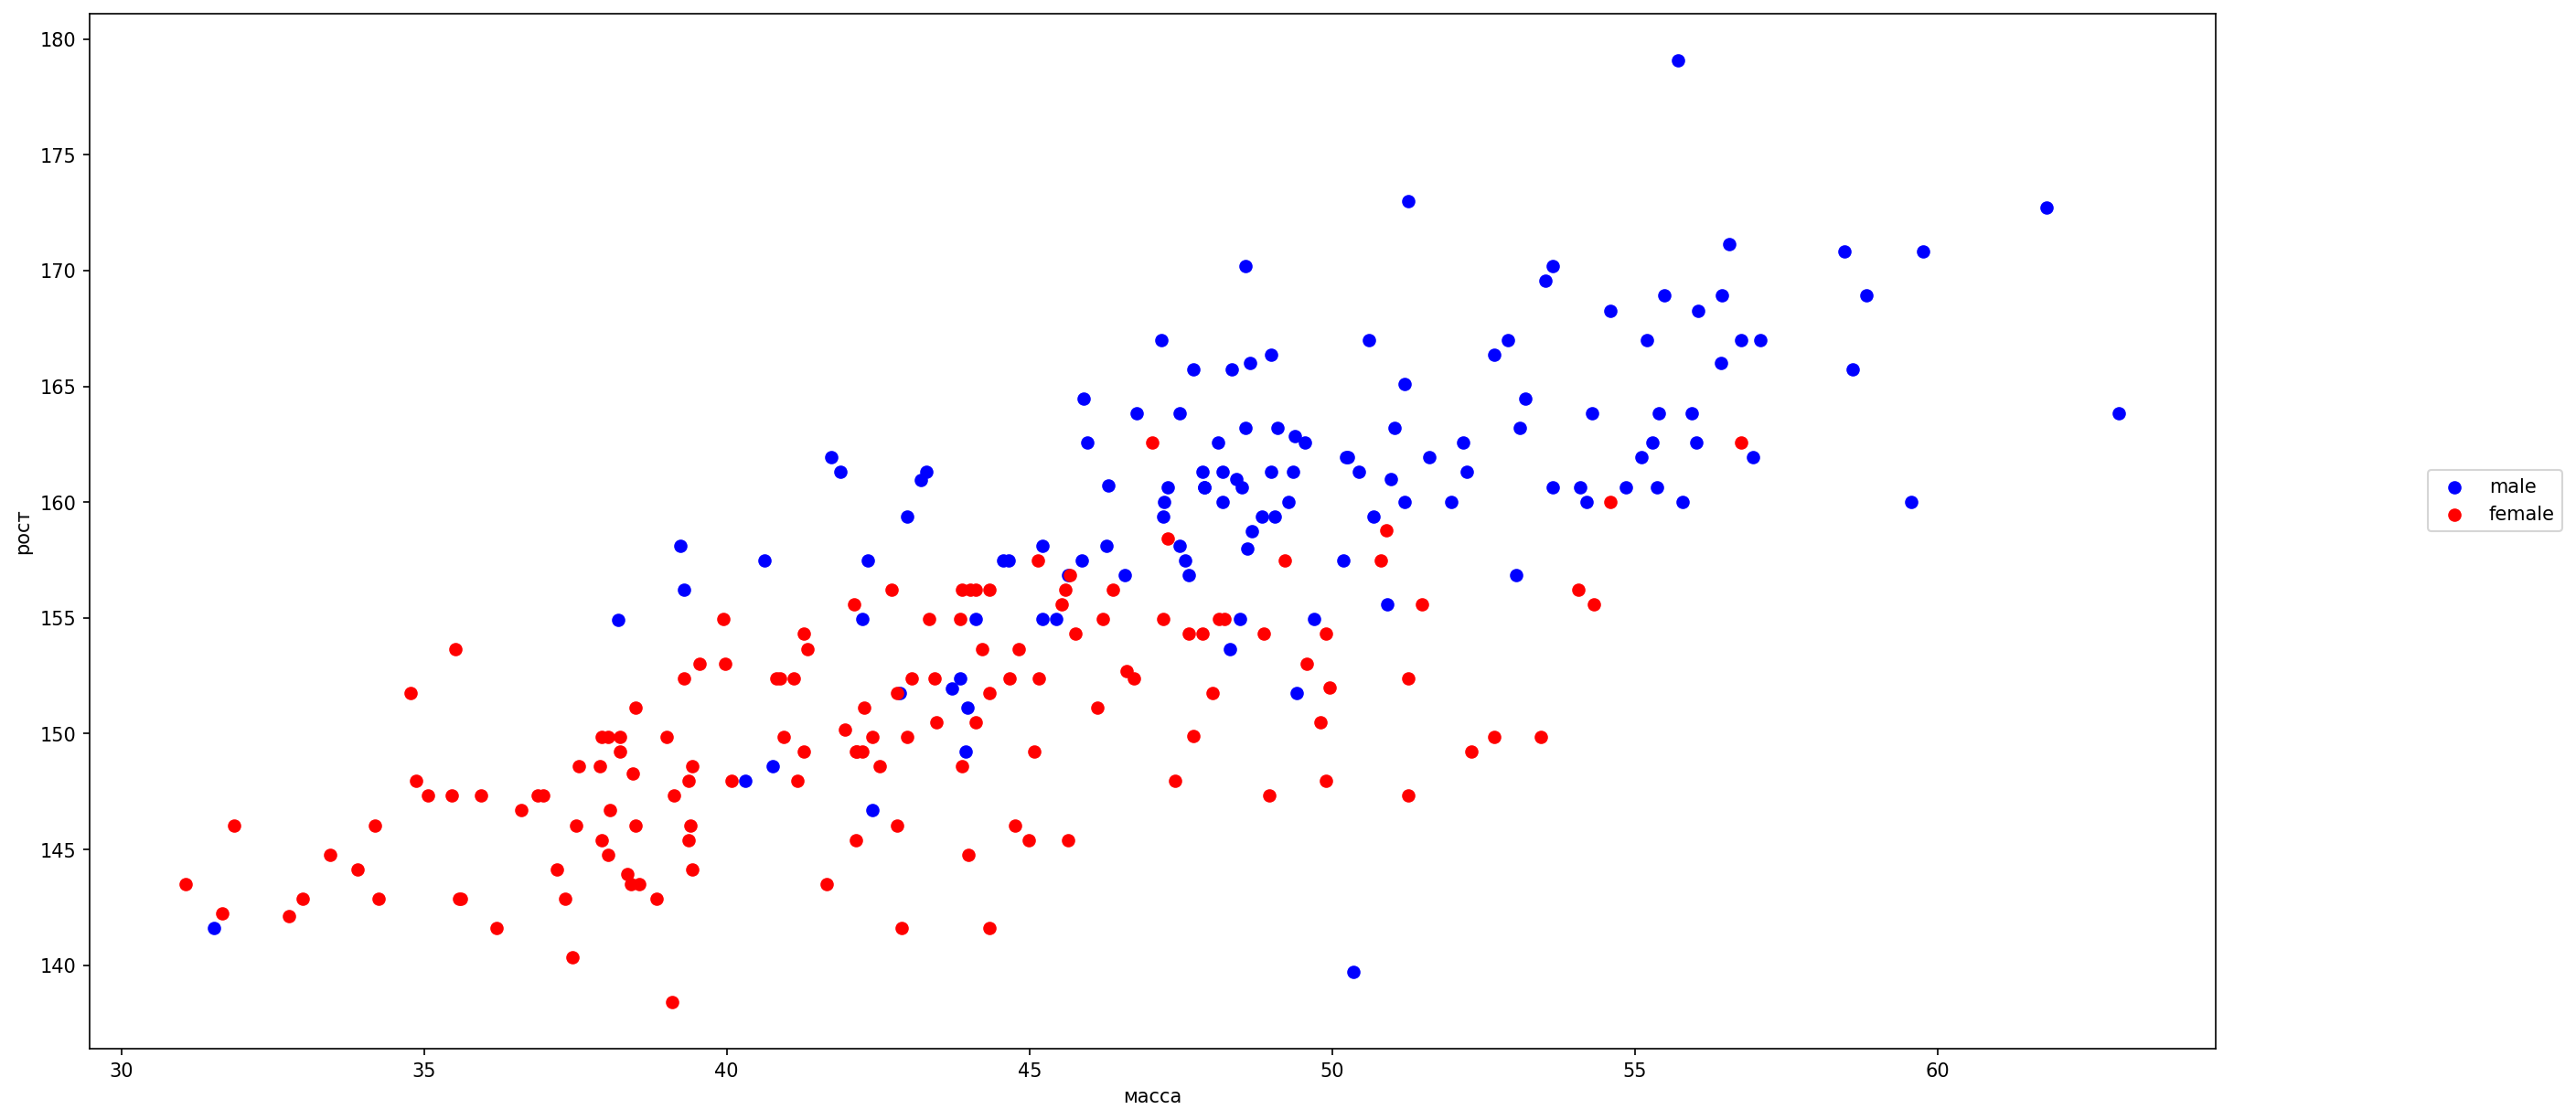

In [50]:
plot(df_sample)

Теперь давайте построим классификатор с использованием библиотек.

In [51]:
from sklearn.model_selection import train_test_split

Разделим выборку на тренировочную и тестовую части, возраст учитывать не будем.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_sample[['height', 'weight']], df_sample['male'], test_size = 0.3, random_state = 1)

Посмотрим на тренировочные данные и их распределение.

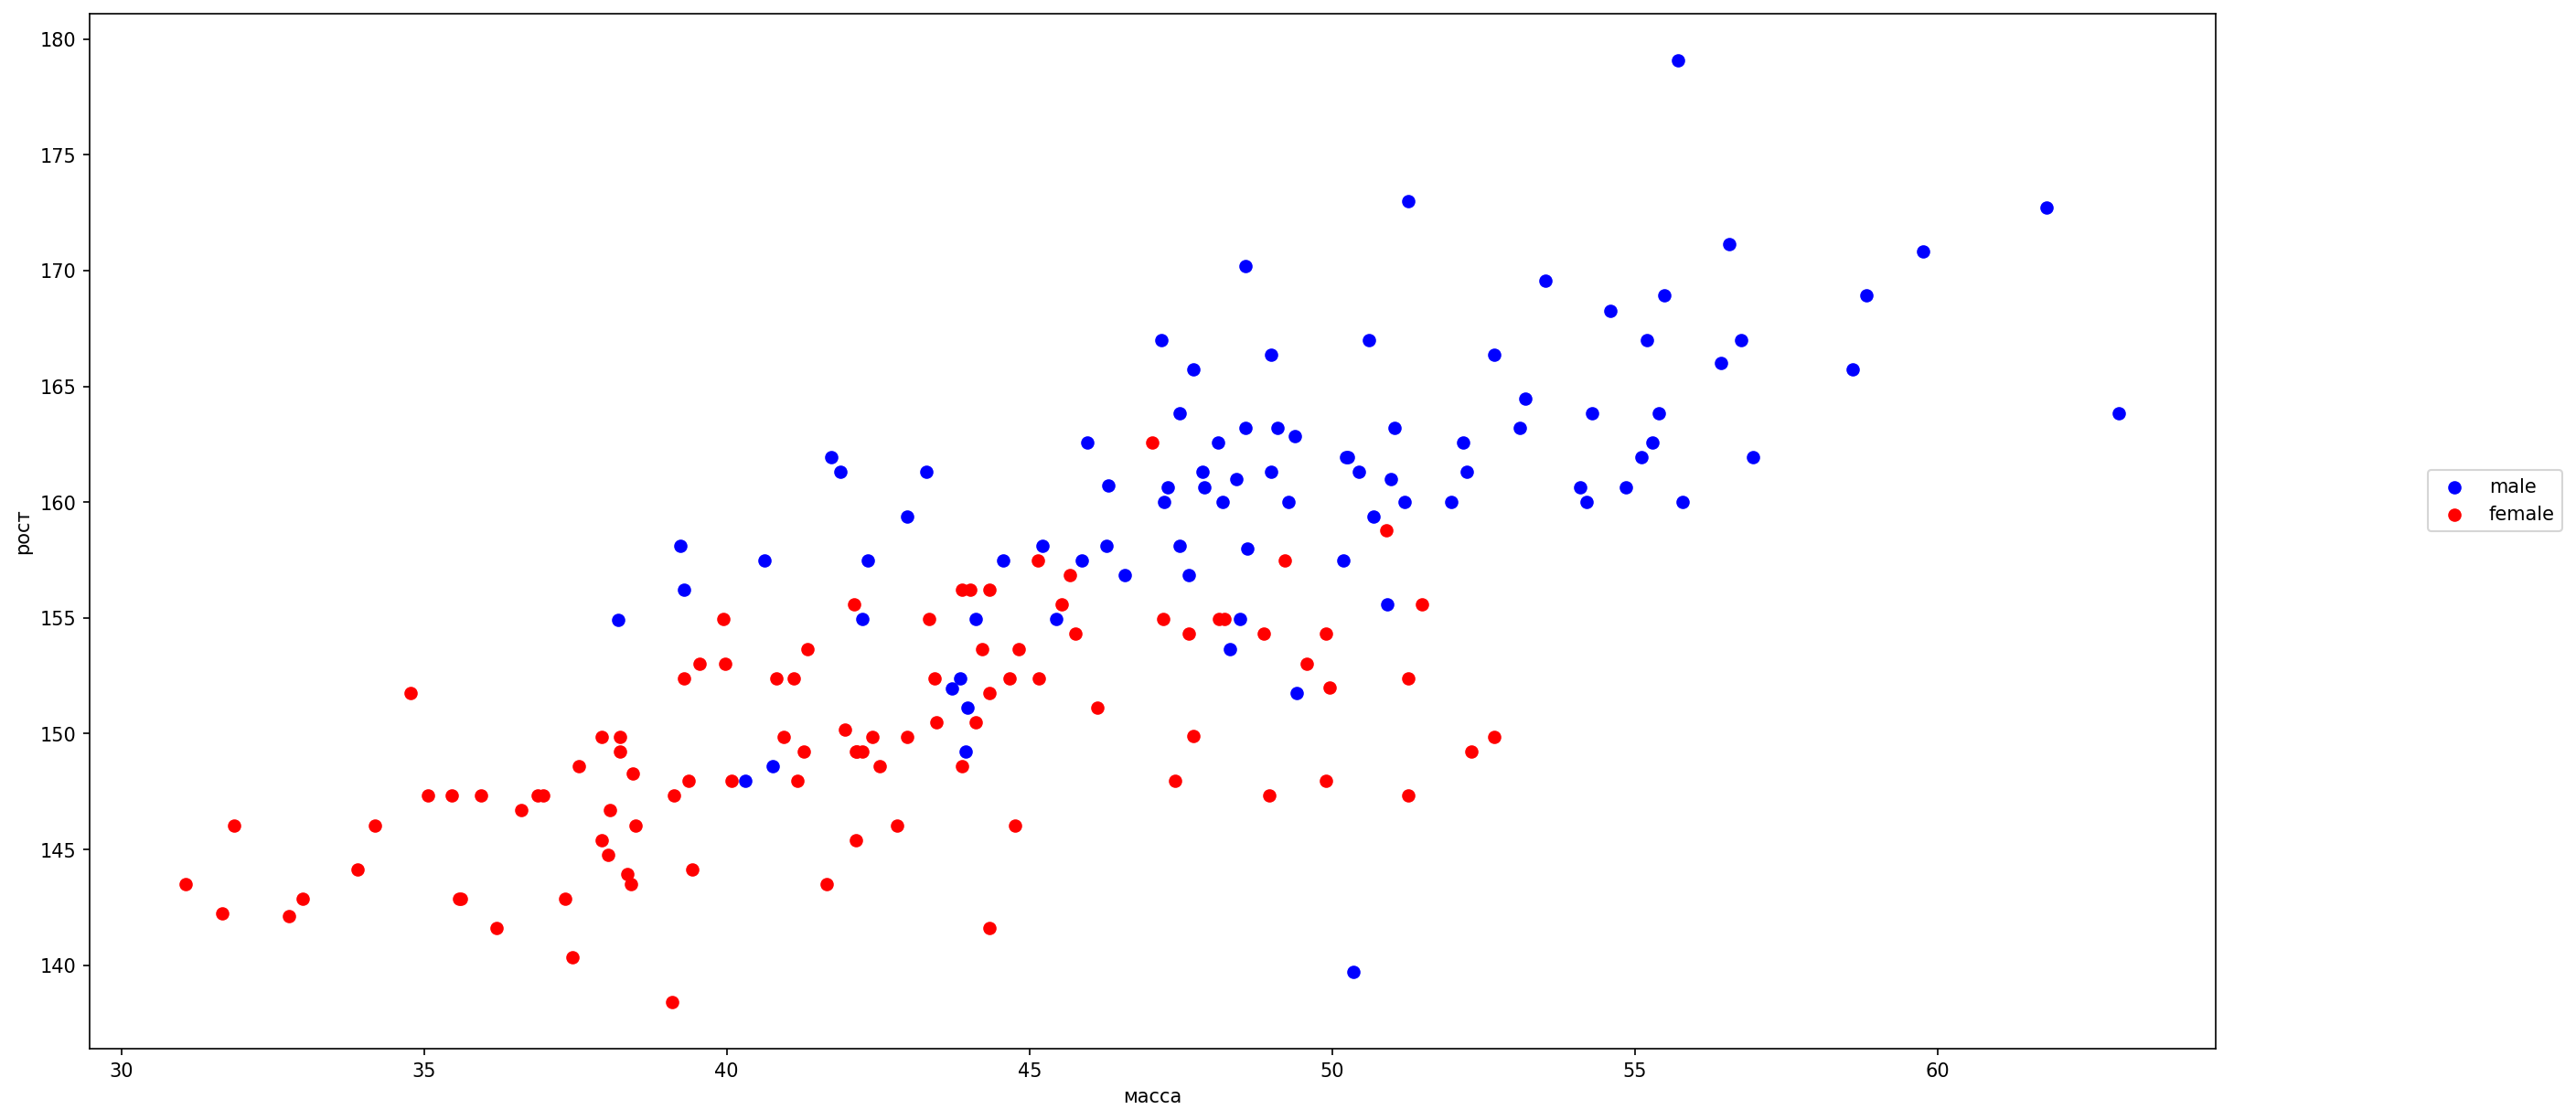

In [53]:
plot(df_sample.loc[X_train.index])

То же самое сделаем с тестовыми данными.

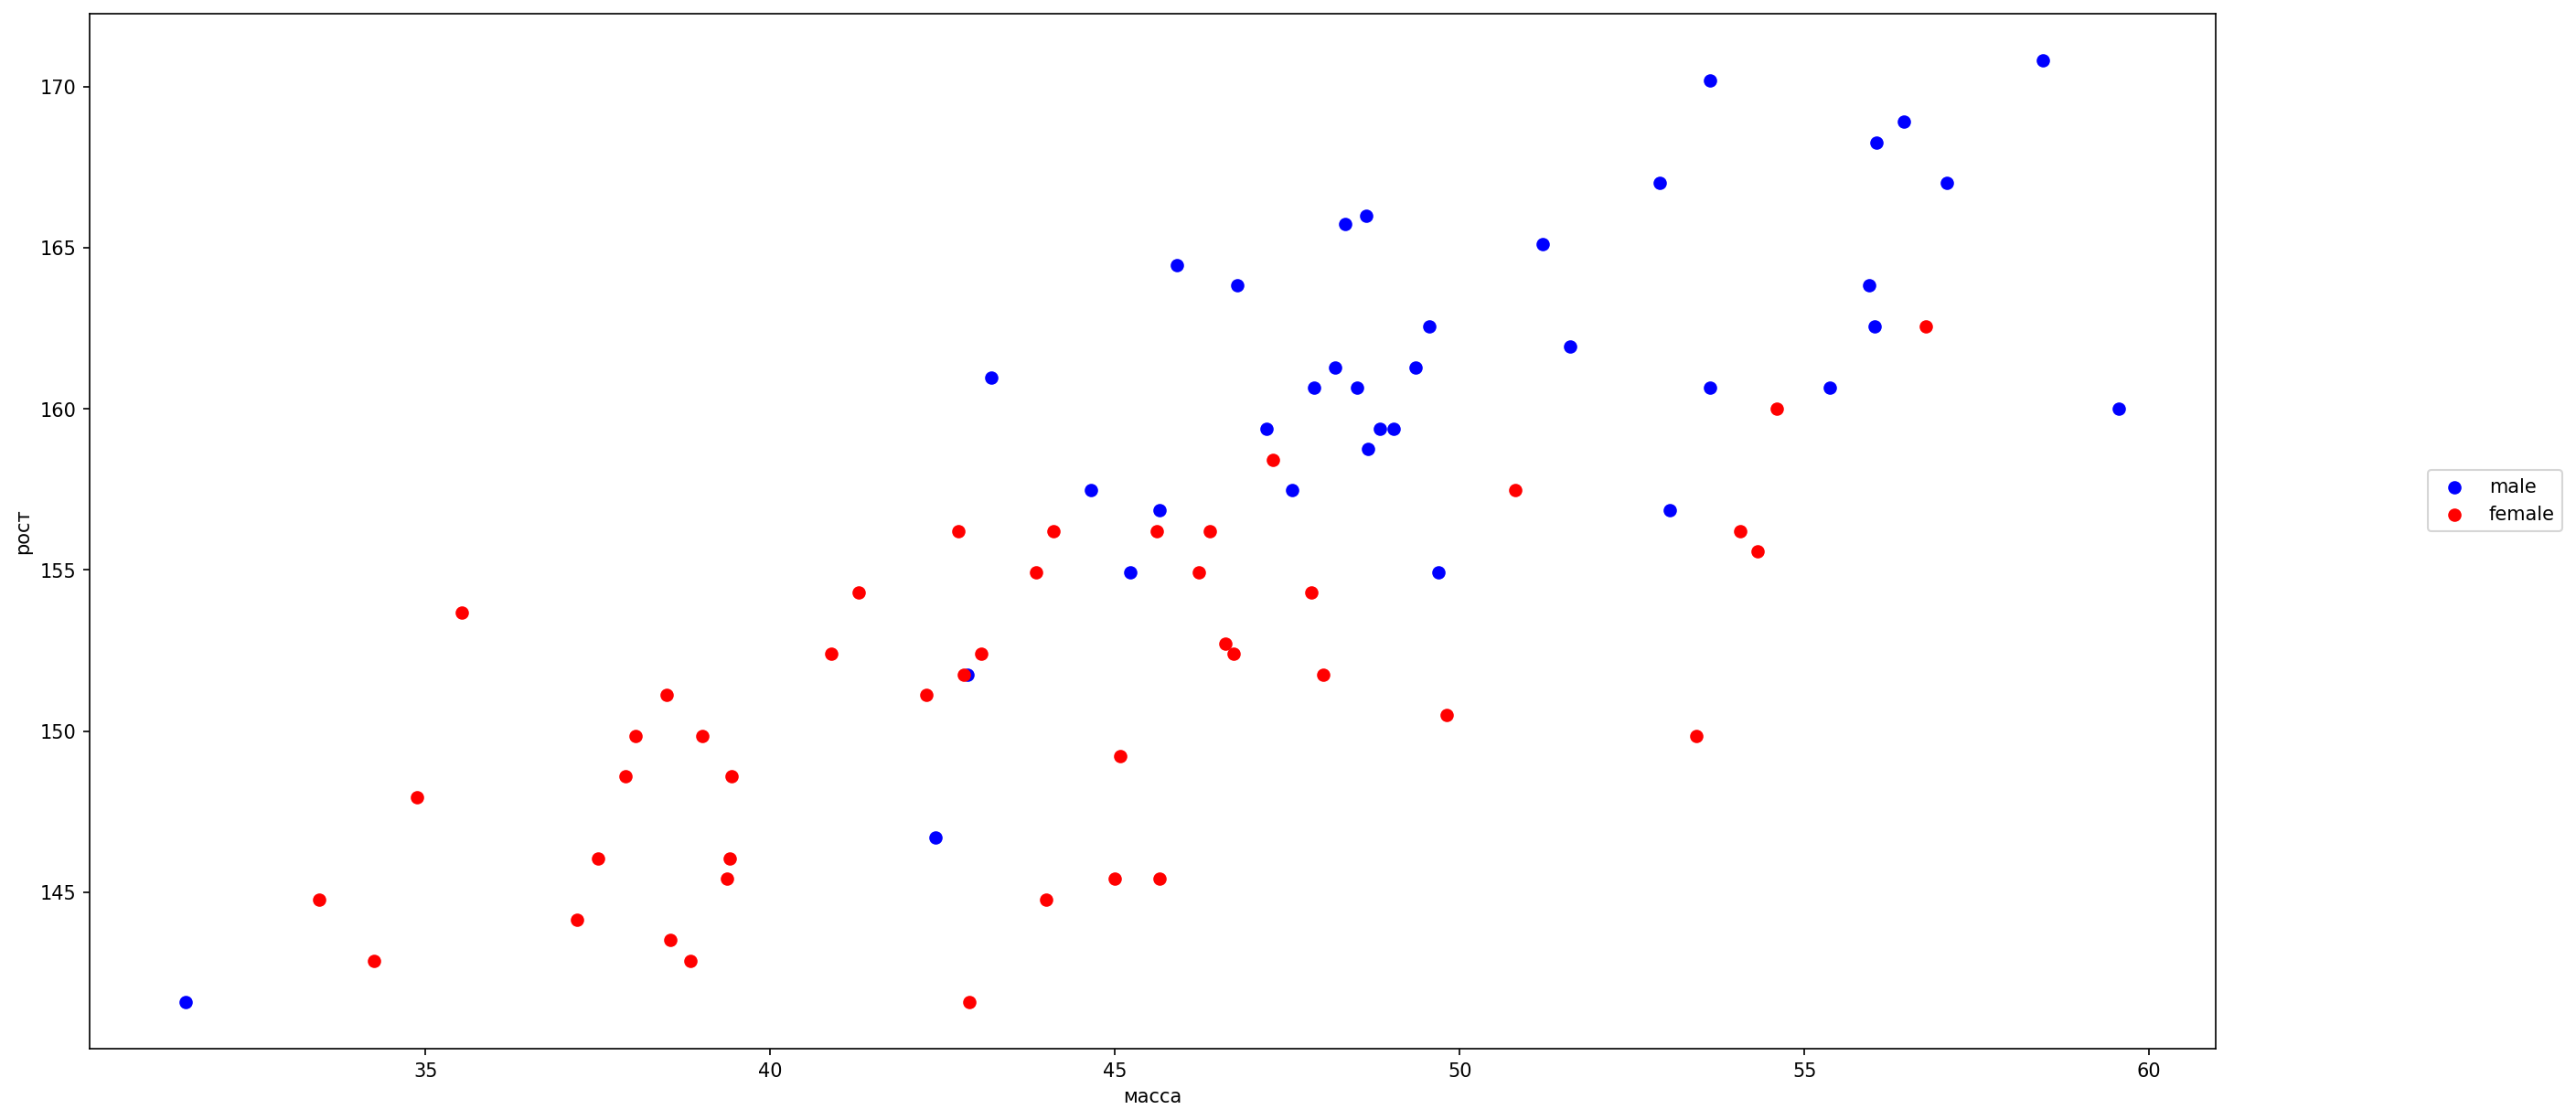

In [54]:
plot(df_sample.loc[X_test.index])

Импортируем скейлер и метрику качества — точность (Accuracy).

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

Мы используем метрический классификатор. **Что бы вам ни говорили, нормируйте (стандартизируйте):**

In [56]:
sc = StandardScaler().fit(X_train)
x_train = sc.transform(X_train)
x_test = sc.transform(X_test)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

Параметр $p$ «отвечает» параметру в расстоянии Минковского:

In [58]:
knn = KNeighborsClassifier(n_neighbors = 5, p = 2)

Обучим наш классификатор:

In [59]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

Посмотрим, что же он выдает на тесте:

In [60]:
knn.predict(x_test)

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1])

Вычислим долю правильных ответов:

In [61]:
accuracy_score(y_test, knn.predict(x_test))

0.810126582278481

Можно смотреть и на вероятности отнесения объектов к назначенному классу. Вероятности вычисляются на основе частоты:

In [62]:
knn.predict_proba(x_test)

array([[0.6, 0.4],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0.4, 0.6],
       [0. , 1. ],
       [1. , 0. ],
       [0.6, 0.4],
       [0. , 1. ],
       [0. , 1. ],
       [0.4, 0.6],
       [0. , 1. ],
       [0.6, 0.4],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.8, 0.2],
       [0.4, 0.6],
       [0.8, 0.2],
       [0.2, 0.8],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.6, 0.4],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.4, 0.6],
       [0. , 1. ],
       [0.4, 0.6],
       [0.6, 0.4],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.8,

In [63]:
x_test[0]

array([-0.01060726,  0.64075622])

Можно проводить и чуть боле глубокую аналитику. Вычислим расстояния до ближайших объектов и индексы самих объектов:

In [64]:
knn.kneighbors([x_test[0]])

(array([[0.08709624, 0.15140611, 0.18923045, 0.20602178, 0.22883682]]),
 array([[ 34,  29,  80, 162,  78]]))

Визуализируем это на плоскости

In [65]:
X_test.iloc[0]

height    154.940000
weight     49.696674
Name: 165, dtype: float64

(45.0, 55.0, 150.0, 160.0)

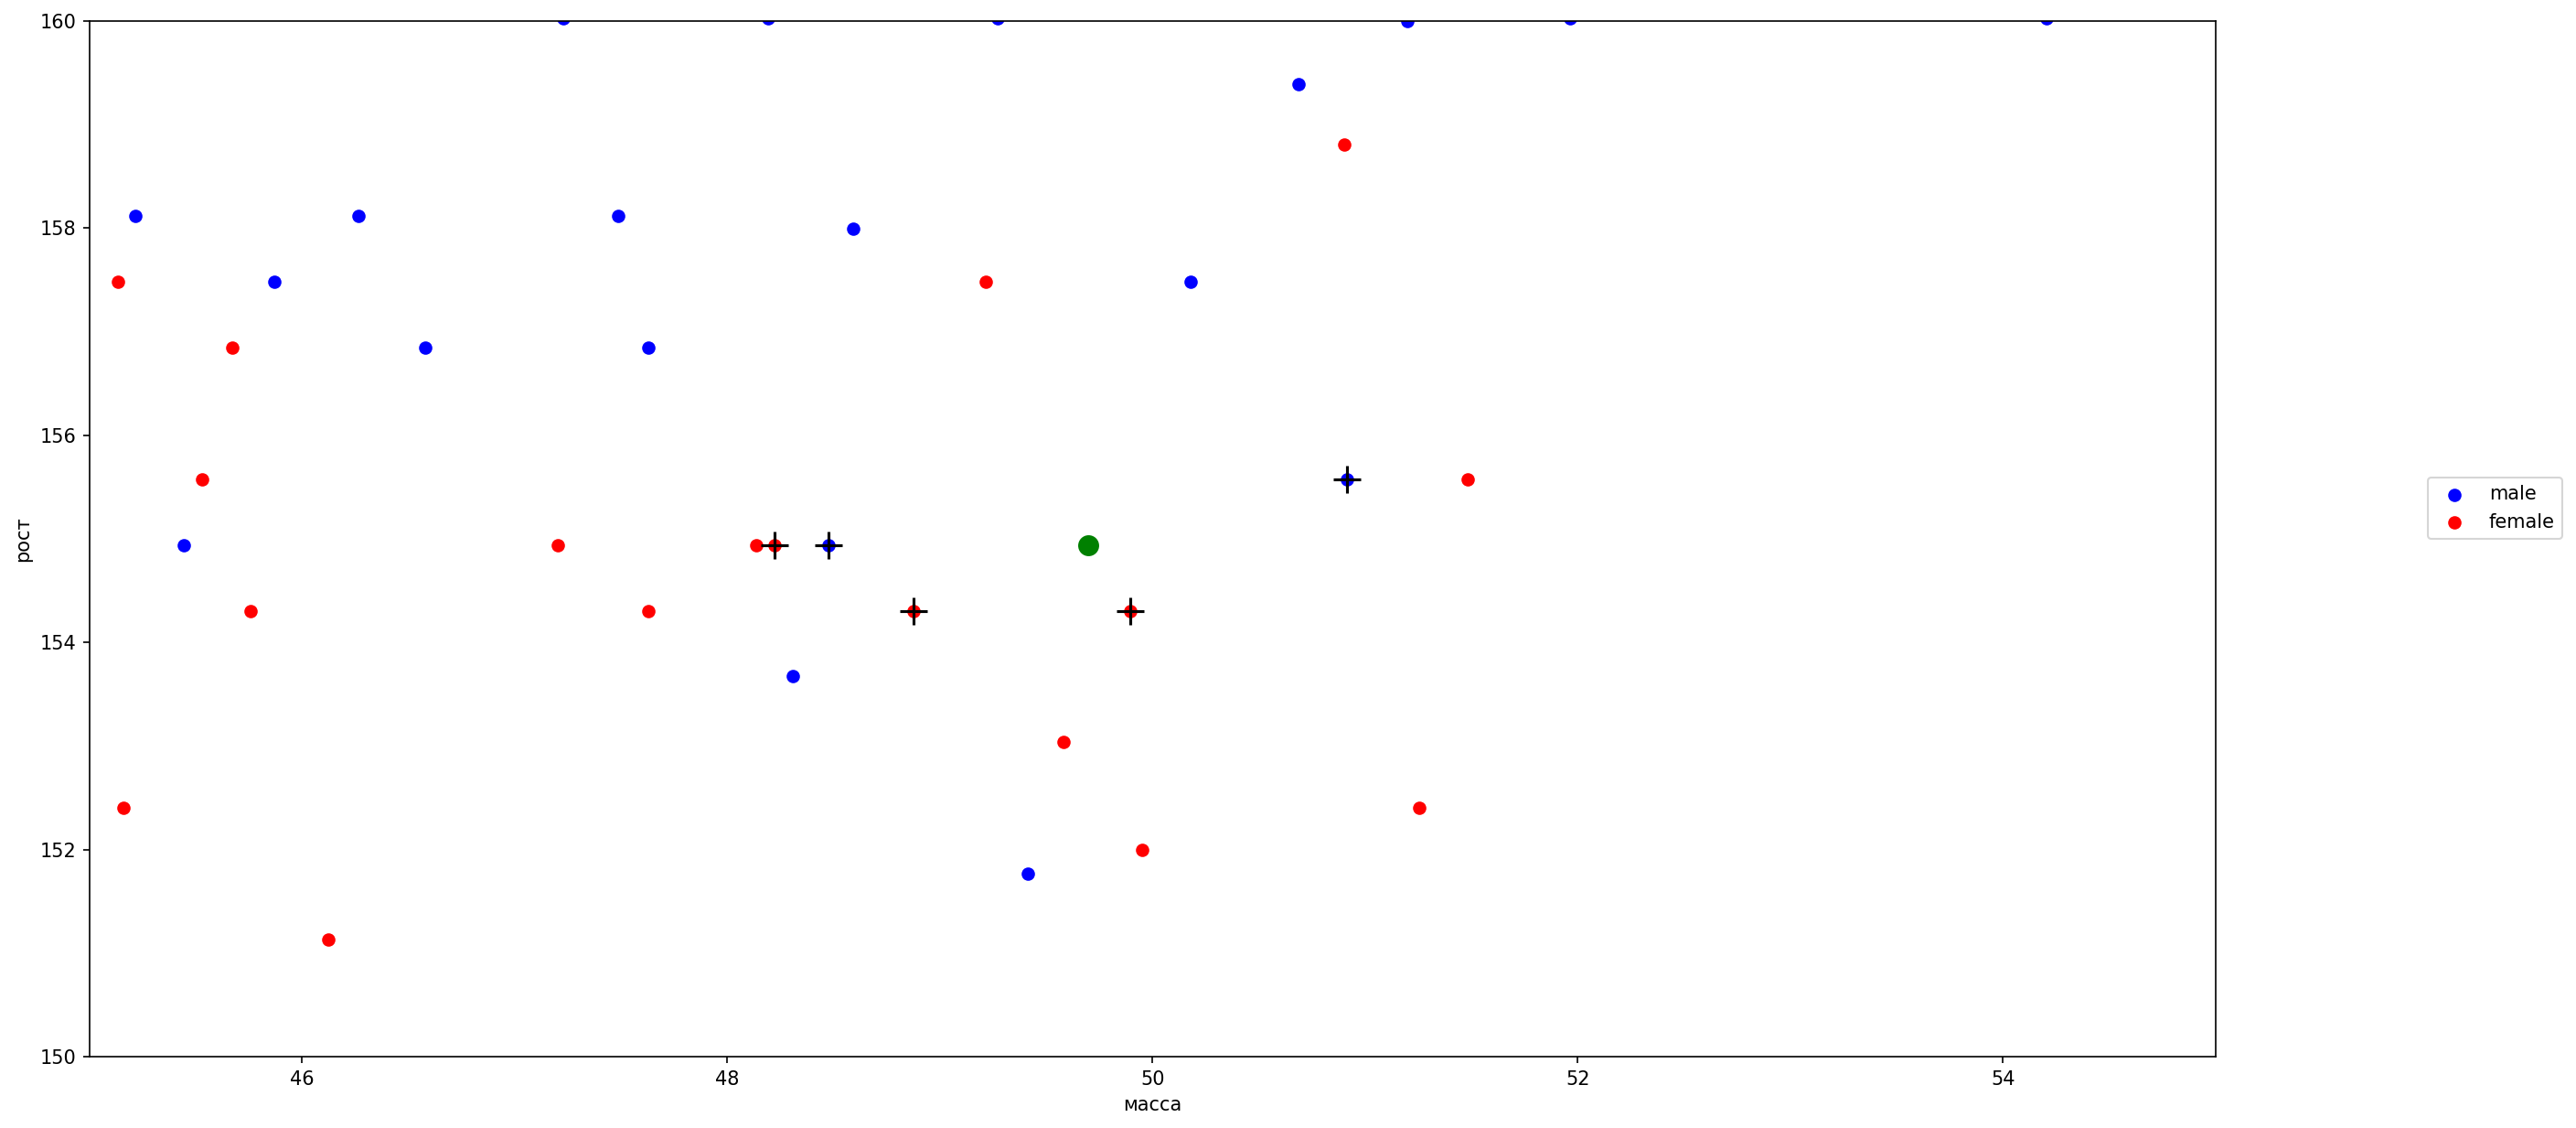

In [66]:
plot(df_sample.loc[X_train.index])
plt.scatter(X_test.iloc[0].weight, X_test.iloc[0].height, marker = 'o', color = 'green', s = 100)
plt.scatter(X_train.iloc[[ 34,  29,  80, 162,  78]].weight, X_train.iloc[[ 34,  29,  80, 162,  78]].height, marker = '+', color = 'black', s = 200)

plt.axis([45, 55, 150, 160])

Предсказание для нового объекта

In [67]:
new_Human = [182, 77]

In [68]:
new_human = sc.transform([new_Human])
new_human

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[3.46102548, 4.87906621]])

In [69]:
knn.predict(new_human)

array([1])

А почему мы выбрали $k = 5$? Пока что наобум. Как поступить?

In [70]:
knn_5 = KNeighborsClassifier(n_neighbors = 5, p = 2)
knn_7 = KNeighborsClassifier(n_neighbors = 7, p = 2)
print(f'Accuracy for k = 5: {accuracy_score(y_test, knn_5.fit(x_train, y_train).predict(x_test))}')
print(f'Accuracy for k = 7: {accuracy_score(y_test, knn_7.fit(x_train, y_train).predict(x_test))}')

Accuracy for k = 5: 0.810126582278481
Accuracy for k = 7: 0.8354430379746836


Правильно ли считать, что надо взять $k = 7$?

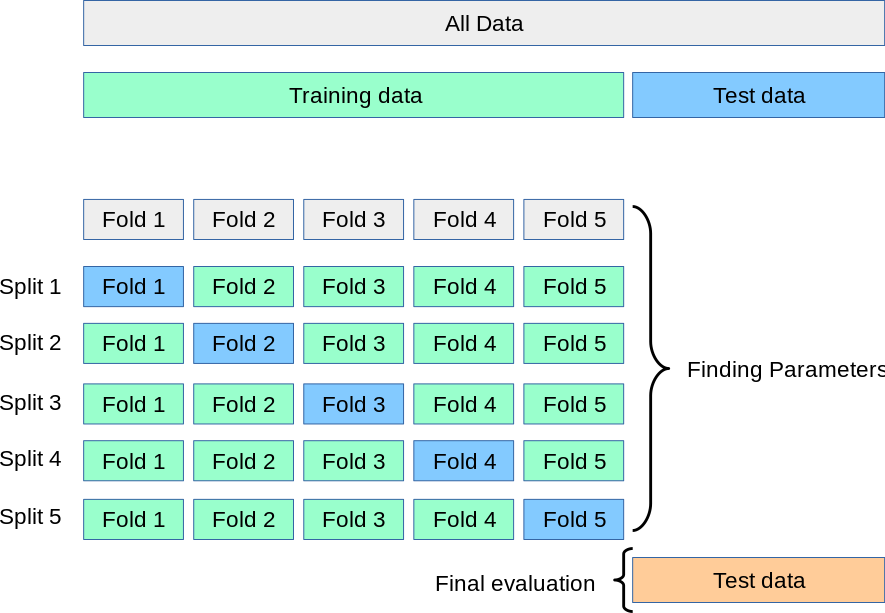

In [71]:
from sklearn.model_selection import GridSearchCV

In [73]:
import numpy as np

In [74]:
parameter_grid = {
    'n_neighbors': np.arange(2, 10, 1),
    'p': [1, 2, 3]
}
grid_searcher = GridSearchCV(estimator = KNeighborsClassifier(),
                             param_grid = parameter_grid,
                             cv = 5,
                             scoring = 'accuracy',
                             n_jobs = -1
                            )

In [75]:
%%time
grid_searcher.fit(x_train, y_train)

CPU times: user 290 ms, sys: 68.1 ms, total: 358 ms
Wall time: 3.84 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': [1, 2, 3]},
             scoring='accuracy')

In [76]:
grid_searcher.best_params_

{'n_neighbors': 9, 'p': 2}

In [77]:
grid_searcher.best_score_

0.8858858858858859

In [78]:
print(f'Accuracy for best: {accuracy_score(y_test, grid_searcher.best_estimator_.predict(x_test))}')

Accuracy for best: 0.8354430379746836
